In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns

In [ ]:
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18

# Loading dataframes

In [3]:
VOTE_DATA_PATH = 'data/votes/'
vote_data_files = os.listdir('data/votes')
vote_data_files = [x for x in vote_data_files if x.startswith('votes_')]

In [100]:
def interpret_position(positions):
    r = positions.copy()
    r = r.apply(lambda x : 1 if x == "Yes" else ( -1 if x == "No" else 0 ))
    
    return r

In [124]:
USEFUL_COLUMNS = ['id','bill.number','congress','member_id','question','position', 'timestamp']

def process_vote_file(file_path):
    print("Processing vote data for {file}".format(file=file_path))
    
    # Read data
    df = pd.read_csv(VOTE_DATA_PATH + file_path)

    # We drop entries without bill number as they lead to invalid bill IDs
    df = df[df['bill.number'].notna()]
    
    # We drop entries without roll call value
    df = df[df['roll_call'].notna()]
    
    # As there can be several votes per bill we need to build a unique ID
    df['id'] = df['bill.bill_id'].map(str) + "-" + df['roll_call'].map(str)

    # Some bill IDs and roll call numbers are poorly filled, leading to duplicates
    df = df.drop_duplicates('id')
    
    # Build timestamps
    df['timestamp'] = pd.to_datetime(df.date.map(str) + " " + df.time.map(str))
    
    # Keep only useful columns
    df = df[USEFUL_COLUMNS]
    
    # Convert position to numeric
    df['position'] = interpret_position(df['position'])
    
    return df

In [131]:
NOMINATION_VOTE = "On the Nomination"
MOTION_VOTE = "On the Motion"
CLOTURE_MOTION_VOTE = "On the Cloture Motion"
BILL_PASSAGE = "On Passage of the Bill"

def build_vote_matrix(questions, data):
    """
    Given a list of questions, build a vote matrix.
    Index are senators IDs, columns are vote IDs and values are the respective positions
    of the senators with respect to the question (Yes, No, blank or NaN if the senator
    did not take part in the vote)
    
    Data should contain the following columns:
        - senators ID (member_id)
        - vote ID (id)
        - position (position)
    """
    vote_matrix = data[data['question'].isin(questions)]
    vote_matrix = vote_matrix.pivot(columns='id', index='member_id', values='position')
    
    return vote_matrix

In [140]:
# Example vote matrix
vm_data1 = process_vote_file(vote_data_files[200])
vm_data2 = process_vote_file(vote_data_files[202])
vm_data = pd.concat([vm_data1.head(10), vm_data2.head(10)]) 

display(vm_data)

vm = build_vote_matrix([NOMINATION_VOTE], vm_data)

display(vm)

Processing vote data for votes_M001176.csv
Processing vote data for votes_N000032.csv


,id,bill.number,congress,member_id,question,position,timestamp
0,hr6-115-221,H.R.6,115,M001176,On the Motion,1,2018-10-03 15:18:00
1,hr302-115-220,H.R.302,115,M001176,On the Motion,-1,2018-10-03 12:01:00
2,hr302-115-219,H.R.302,115,M001176,On the Cloture Motion,-1,2018-10-01 17:31:00
3,pn1677-115-218,PN1677,115,M001176,On the Nomination,1,2018-09-27 12:41:00
4,pn2073-115-217,PN2073,115,M001176,On the Nomination,-1,2018-09-26 13:46:00
5,pn2073-115-216,PN2073,115,M001176,On the Cloture Motion,-1,2018-09-25 14:45:00
6,pn2048-115-215,PN2048,115,M001176,On the Nomination,-1,2018-09-25 14:16:00
7,pn2048-115-214,PN2048,115,M001176,On the Cloture Motion,0,2018-09-24 18:02:00
8,pn1447-115-213,PN1447,115,M001176,On the Nomination,0,2018-09-24 17:32:00
9,hr6157-115-212,H.R.6157,115,M001176,On the Conference Report,1,2018-09-18 12:45:00


id,pn1447-115-213,pn1677-115-218,pn2048-115-215,pn2073-115-217
member_id,,,,
M001176,0,1,-1,-1
N000032,1,1,1,-1


In [181]:
# Compiling senators from all congresses
raw_senators = pd.DataFrame()

for i in range (115, 80 - 1, -1):
    df = pd.read_csv("data/senate_members/senate_members_{congress}.csv".format(congress = i))
    df['congress'] = i
    raw_senators = pd.concat([raw_senators, df], sort=False)
    
    
# Compiling commities
raw_commities = pd.DataFrame()

for i in range (115, 110 - 1, -1):
    df = pd.read_csv("data/commities/commities_{congress}.csv".format(congress = i))
    df['congress'] = i
    raw_commities = pd.concat([raw_senators, df], sort=False)
    
    
# Retrieving votes
raw_votes = pd.read_csv("data/votes/votes.csv")

#Retrieving lobbies
raw_lobbies = pd.read_csv("data/lobby/lobby.csv")

In [182]:
raw_senators.columns

Index(['Unnamed: 0', 'api_uri', 'contact_form', 'crp_id', 'cspan_id',
       'date_of_birth', 'dw_nominate', 'facebook_account', 'fax',
       'fec_candidate_id', 'first_name', 'gender', 'google_entity_id',
       'govtrack_id', 'icpsr_id', 'id', 'ideal_point', 'in_office',
       'last_name', 'last_updated', 'leadership_role', 'lis_id', 'middle_name',
       'missed_votes', 'missed_votes_pct', 'next_election', 'ocd_id', 'office',
       'party', 'phone', 'rss_url', 'senate_class', 'seniority', 'short_title',
       'state', 'state_rank', 'suffix', 'title', 'total_present',
       'total_votes', 'twitter_account', 'url', 'votes_with_party_pct',
       'votesmart_id', 'youtube_account', 'congress'],
      dtype='object')

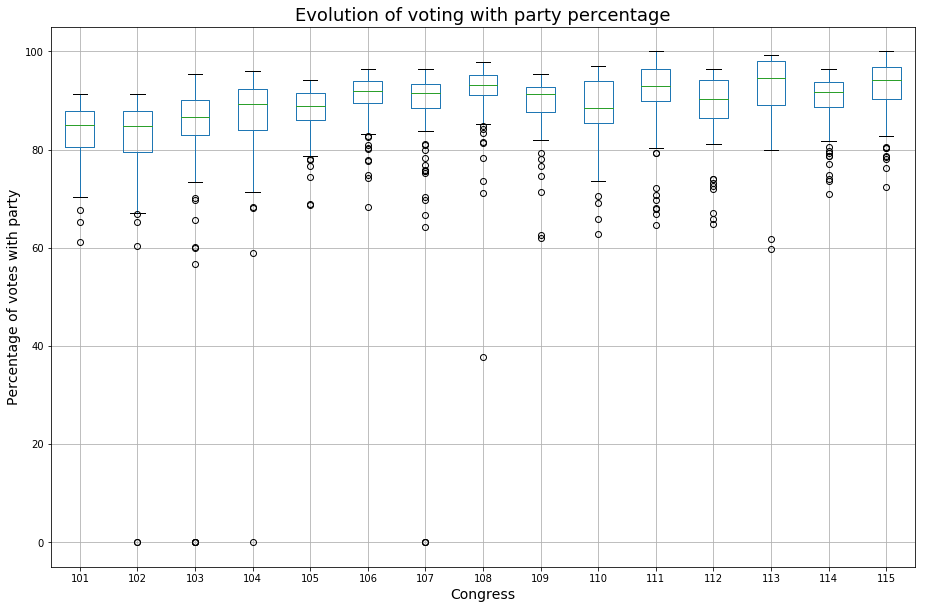

In [227]:
# Do senators tend to vote more and more with their party ?

data = raw_senators[raw_senators['congress'] > 100]
ax = data.boxplot(column='votes_with_party_pct', by='congress', figsize=(15,10))
ax.set(xlabel="Congress", ylabel="Percentage of votes with party")
ax.get_figure().suptitle("")

plt.title("Evolution of voting with party percentage")
plt.show()

Text(0.5,1,'Proportion of women in senate')

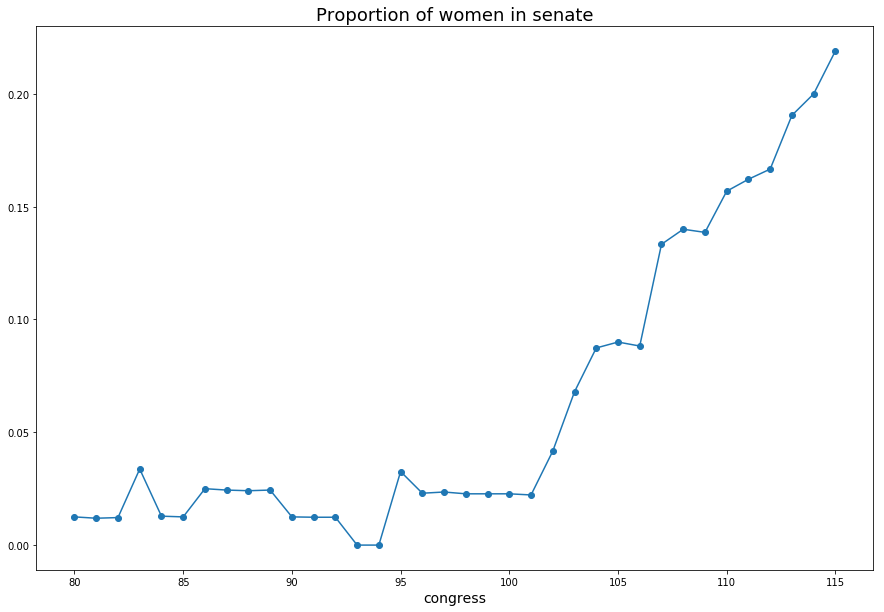

In [317]:
gc = gender_count.unstack()
gc.columns = gc.columns.droplevel()
# Compute gender percentages
gc = gc.div(gc.sum(axis=1),axis=0).fillna(0)
gc['F'].plot(kind='line', figsize=(15,10), marker='o', linestyle='-')
plt.title("Proportion of women in senate")

In [45]:
raw_votes.columns

Index(['Unnamed: 0', 'amendment.api_uri', 'amendment.number',
       'amendment.sponsor', 'amendment.sponsor_id', 'amendment.sponsor_party',
       'amendment.sponsor_state', 'amendment.sponsor_uri', 'bill.api_uri',
       'bill.bill_id', 'bill.latest_action', 'bill.number', 'bill.sponsor_id',
       'bill.title', 'chamber', 'congress', 'date',
       'democratic.majority_position', 'democratic.no',
       'democratic.not_voting', 'democratic.present', 'democratic.yes',
       'description', 'document_number', 'document_title', 'independent.no',
       'independent.not_voting', 'independent.present', 'independent.yes',
       'nomination.agency', 'nomination.name', 'nomination.nomination_id',
       'nomination.number', 'question', 'republican.majority_position',
       'republican.no', 'republican.not_voting', 'republican.present',
       'republican.yes', 'result', 'roll_call', 'session', 'source',
       'tie_breaker', 'tie_breaker_vote', 'time', 'total.no',
       'total.not_voting